In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#set a random seed for replication
seed = 62583
np.random.seed(seed)
#read in training data
df = pd.read_csv('final_dataset.csv')

In [51]:
print(df['GlobalClass'].unique())

['Benign' 'Light Attack' 'Light Benign' 'Heavy Attack' 'Heavy Benign']


In [52]:
df['GlobalClass'].value_counts()


Benign          83183
Heavy Benign    68057
Light Benign    24403
Heavy Attack     5764
Light Attack     2462
Name: GlobalClass, dtype: int64

In [53]:
df['GlobalClass'] = df['GlobalClass'].map({'Benign':0,'Light Benign':0,'Heavy Benign':0, 'Light Attack':1, 'Heavy Attack':2})

Undersampling Benign to balance out the categories more

In [54]:
c0 = df[df['GlobalClass'] == 0]
c1 = df[df['GlobalClass'] == 1]
c2 = df[df['GlobalClass'] == 2]
df_0 = c0.sample(2462)
df_2 = c2.sample(2462)
undersampled_df = pd.concat([df_0, c1, df_2],axis=0)
df = undersampled_df

In [55]:
df['GlobalClass'].value_counts()

0    2462
1    2462
2    2462
Name: GlobalClass, dtype: int64

In [56]:
feature_names = list(df.columns)
print(feature_names)
feature_names.remove('GlobalClass')
target_names = ['0', '1', '2']

['A_frequency', 'PTR_frequency', 'TXT_frequency', 'rr_count', 'rr_name_entropy', 'rr_name_length', 'distinct_ns', 'ttl_mean', 'ttl_variance', 'FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric', 'entropy', 'special', 'labels', 'labels_max', 'labels_average', 'longest_word', 'sld', 'len', 'subdomain', 'GlobalClass']


In [57]:
from sklearn.model_selection import train_test_split

#create feature and targets
features = df.drop('GlobalClass', axis=1)
target = df['GlobalClass']
#split data into 80% training and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=seed)

In [58]:
#size for the sets
print('size of X_train:', X_train.shape)
print('size of X_test:', X_test.shape)
print('size of y_train:', y_train.shape)
print('size of y_test:', y_test.shape)

size of X_train: (5908, 23)
size of X_test: (1478, 23)
size of y_train: (5908,)
size of y_test: (1478,)


In [59]:
from sklearn.ensemble import HistGradientBoostingClassifier
hgb_classifier = HistGradientBoostingClassifier(class_weight='balanced')
hgb_classifier.fit(X_train,y_train)
y_pred_hgb = hgb_classifier.predict(X_test)
hgb_classifier.score(X_train, y_train)

0.7894380501015572

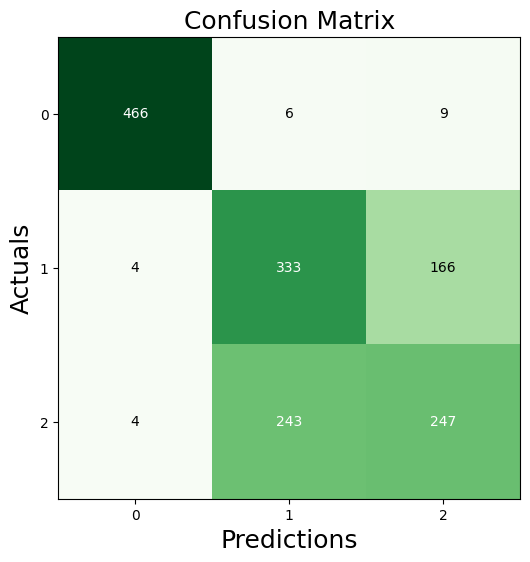

In [60]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
cm_hgb = confusion_matrix(y_test, y_pred_hgb)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm_hgb, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [61]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
accuracy_score(y_test, y_pred_hgb)

0.7077131258457375

In [62]:
pred_prob = hgb_classifier.predict_proba(X_test)
roc_auc_score(y_test, pred_prob, multi_class='ovo')

0.8629670948973756

In [63]:
acc_hgb = cross_val_score(estimator = hgb_classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy of hgb: {:.2f} %".format(acc_hgb.mean()*100))
print("SD of hgb: {:.2f} %".format(acc_hgb.std()*100))
print(classification_report(y_test, y_pred_hgb))

Accuracy of hgb: 69.25 %
SD of hgb: 1.32 %
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       481
           1       0.57      0.66      0.61       503
           2       0.59      0.50      0.54       494

    accuracy                           0.71      1478
   macro avg       0.71      0.71      0.71      1478
weighted avg       0.71      0.71      0.71      1478



In [64]:
from sklearn.model_selection import GridSearchCV
parameters_hgb = [{'max_iter': [1000,1200,1500],
                'learning_rate': [0.1],
                'max_depth' : [25, 50, 75],
                'l2_regularization': [1.5],
                'scoring': ['f1_micro']}]
grid_search_hgb = GridSearchCV(estimator = hgb_classifier,
                           param_grid = parameters_hgb,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search_hgb.fit(X_train, y_train)
best_accuracy_hgb = grid_search_hgb.best_score_
best_paramaeter_hgb = grid_search_hgb.best_params_  
print("Best Accuracy of HGB: {:.2f} %".format(best_accuracy_hgb.mean()*100))
print("Best Parameter of HGB:", best_paramaeter_hgb)

Best Accuracy of HGB: 66.52 %
Best Parameter of HGB: {'l2_regularization': 1.5, 'learning_rate': 0.1, 'max_depth': 25, 'max_iter': 1000, 'scoring': 'f1_micro'}


In [65]:
from trustee import ClassificationTrustee
from sklearn import tree
import graphviz


trustee = ClassificationTrustee(expert=hgb_classifier)
trustee.fit(X_train, y_train, num_iter=50, num_stability_iter=10, samples_size=0.3, verbose=True)

# Get the best explanation from Trustee
dt, pruned_dt, agreement, reward = trustee.explain()
print(f"Model explanation training (agreement, fidelity): ({agreement}, {reward})")
print(f"Model Explanation size: {dt.tree_.node_count}")
print(f"Top-k Prunned Model explanation size: {pruned_dt.tree_.node_count}")

# Use explanations to make predictions
dt_y_pred = dt.predict(X_test)
pruned_dt_y_pred = pruned_dt.predict(X_test)

# Evaluate accuracy and fidelity of explanations
print("Model explanation global fidelity report:")
print(classification_report(y_pred_hgb, dt_y_pred))
print("Top-k Model explanation global fidelity report:")
print(classification_report(y_pred_hgb, pruned_dt_y_pred))

print("Model explanation score report:")
print(classification_report(y_test, dt_y_pred))
print("Top-k Model explanation score report:")
print(classification_report(y_test, pruned_dt_y_pred))


Initializing training dataset using HistGradientBoostingClassifier(class_weight='balanced') as expert model
Expert model score: 0.7806106973079788
Initializing Trustee outer-loop with 10 iterations
########## Outer-loop Iteration 0/10 ##########
Initializing Trustee inner-loop with 10 iterations
########## Inner-loop Iteration 0/50 ##########
Sampling 1240 points from training dataset with (4135, 4135) entries
Student model 0-0 trained with depth 17 and 171 leaves:
Student model score: 0.7997642869508294
Student model 0-0 fidelity: 0.7997642869508294
########## Inner-loop Iteration 1/50 ##########
Sampling 1240 points from training dataset with (4507, 4507) entries
Student model 0-1 trained with depth 16 and 162 leaves:
Student model score: 0.8476046891058419
Student model 0-1 fidelity: 0.8476046891058419
########## Inner-loop Iteration 2/50 ##########
Sampling 1240 points from training dataset with (4879, 4879) entries
Student model 0-2 trained with depth 18 and 165 leaves:
Student mo

/home/emily_hu/venv/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/emily_hu/venv/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [66]:
# Output decision tree to pdf
dot_data = tree.export_graphviz(
    dt,
    class_names=target_names,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    special_characters=True,
)


In [67]:
import pickle

with open('dot_data.pkl', 'wb') as f:  # open a text file
    pickle.dump(dot_data, f)
with open('pruned_dt.pkl', 'wb') as f:  # open a text file
    pickle.dump(pruned_dt, f)
with open('dt.pkl', 'wb') as f:
    pickle.dump(dt, f)